# Prediction model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

/Users/Home/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Import data
Might still need to clean up the files some after import

In [2]:
path = '../Clean Data'
X_fn = 'X.csv'
y_fn = 'y.csv'
X_path = os.path.join(path, X_fn)
y_path = os.path.join(path, y_fn)

X = pd.read_csv(X_path)
y = pd.read_csv(y_path)

In [3]:
X.head()

,Unnamed: 0,cluster_id_6,Year,nameplate_capacity,DATETIME,GROSS LOAD (MW),"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed","Wind Output, % of Load",1-hr MW change,1-hr % change,Net Load (MW),Net Load Change (MW),Month,NG Price ($/mcf),All coal,Lignite,Subbituminous
0,0,0,2007,5949.0,2007-01-01 00:00:00,4596.0,30428.0,2790.0,1074.0,38.494624,3.529644,NaN,NaN,29354.0,NaN,1,6.42,25.1475,20.0275,28.115
1,1,0,2007,5949.0,2007-01-01 01:00:00,4566.0,30133.0,2790.0,922.6,33.068100,3.061760,-151.4,-14.096834,29210.4,-143.6,1,6.42,25.1475,20.0275,28.115
2,2,0,2007,5949.0,2007-01-01 02:00:00,4667.0,29941.0,2790.0,849.2,30.437276,2.836245,-73.4,-7.955777,29091.8,-118.6,1,6.42,25.1475,20.0275,28.115
3,3,0,2007,5949.0,2007-01-01 03:00:00,4668.0,29949.0,2790.0,1056.3,37.860215,3.526996,207.1,24.387659,28892.7,-199.1,1,6.42,25.1475,20.0275,28.115
4,4,0,2007,5949.0,2007-01-01 04:00:00,4685.0,30248.0,2790.0,837.1,30.003584,2.767456,-219.2,-20.751680,29410.9,518.2,1,6.42,25.1475,20.0275,28.115


Rename the cluster column to just `cluster`. This won't be needed once we export from the group classification with the correct column name

In [4]:
X.rename(columns={'cluster_id_6':'cluster'}, inplace=True)

### One-hot encoding of the cluster variable
I'm trying to make this easy for using with different numbers of clusters

In [5]:
cluster_ids = X['cluster'].unique()
for cluster in cluster_ids:
    X['cluster_{}'.format(cluster)] = np.eye(len(cluster_ids))[X['cluster'],cluster]

In [6]:
X.head()

,Unnamed: 0,cluster,Year,nameplate_capacity,DATETIME,GROSS LOAD (MW),"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed",...,NG Price ($/mcf),All coal,Lignite,Subbituminous,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
0,0,0,2007,5949.0,2007-01-01 00:00:00,4596.0,30428.0,2790.0,1074.0,38.494624,...,6.42,25.1475,20.0275,28.115,1.0,0.0,0.0,0.0,0.0,0.0
1,1,0,2007,5949.0,2007-01-01 01:00:00,4566.0,30133.0,2790.0,922.6,33.068100,...,6.42,25.1475,20.0275,28.115,1.0,0.0,0.0,0.0,0.0,0.0
2,2,0,2007,5949.0,2007-01-01 02:00:00,4667.0,29941.0,2790.0,849.2,30.437276,...,6.42,25.1475,20.0275,28.115,1.0,0.0,0.0,0.0,0.0,0.0
3,3,0,2007,5949.0,2007-01-01 03:00:00,4668.0,29949.0,2790.0,1056.3,37.860215,...,6.42,25.1475,20.0275,28.115,1.0,0.0,0.0,0.0,0.0,0.0
4,4,0,2007,5949.0,2007-01-01 04:00:00,4685.0,30248.0,2790.0,837.1,30.003584,...,6.42,25.1475,20.0275,28.115,1.0,0.0,0.0,0.0,0.0,0.0


In [7]:
X.tail()

,Unnamed: 0,cluster,Year,nameplate_capacity,DATETIME,GROSS LOAD (MW),"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed",...,NG Price ($/mcf),All coal,Lignite,Subbituminous,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
473329,473329,5,2015,11476.0,2015-12-31 19:00:00,7516.0,39908.77734,16170.0,3824.932373,23.654498,...,2.23,28.53,24.04,32.55,0.0,0.0,0.0,0.0,0.0,1.0
473330,473330,5,2015,11476.0,2015-12-31 20:00:00,6552.0,38736.85938,16170.0,4625.632813,28.606264,...,2.23,28.53,24.04,32.55,0.0,0.0,0.0,0.0,0.0,1.0
473331,473331,5,2015,11476.0,2015-12-31 21:00:00,5944.0,37587.70313,16170.0,4957.714844,30.659956,...,2.23,28.53,24.04,32.55,0.0,0.0,0.0,0.0,0.0,1.0
473332,473332,5,2015,11476.0,2015-12-31 22:00:00,5698.0,36356.26172,16170.0,4699.097656,29.060592,...,2.23,28.53,24.04,32.55,0.0,0.0,0.0,0.0,0.0,1.0
473333,473333,5,2015,11476.0,2015-12-31 23:00:00,5365.0,35150.33984,16170.0,4313.125000,26.673624,...,2.23,28.53,24.04,32.55,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
y.tail()

,Unnamed: 0,DATETIME,cluster_id_6,Gen Change (MW)
473329,473329,2015-12-31 19:00:00,5,-20.0
473330,473330,2015-12-31 20:00:00,5,-964.0
473331,473331,2015-12-31 21:00:00,5,-608.0
473332,473332,2015-12-31 22:00:00,5,-246.0
473333,473333,2015-12-31 23:00:00,5,-333.0


### Drop unnecessary columns and replace nan's with 0

In [9]:
X_cols = ['nameplate_capacity', 'GROSS LOAD (MW)', 'ERCOT Load, MW',
          'Total Wind Installed, MW', 'Total Wind Output, MW', 'Net Load Change (MW)',
          'NG Price ($/mcf)', 'All coal', 'Lignite', 'Subbituminous']
X_cluster_cols = ['cluster_{}'.format(cluster) for cluster in cluster_ids]

X_clean = X.loc[:,X_cols+X_cluster_cols]
X_clean.fillna(0, inplace=True)

y_clean = y.loc[:,'Gen Change (MW)']
y_clean.fillna(0, inplace=True)

In [10]:
print X_clean.shape
print y_clean.shape

(473334, 16)
(473334,)


### Split into training, validation, testing

In [11]:
X_train = X_clean.loc[(X['Year']<2012),:]
y_train = y_clean.loc[(X['Year']<2012)]

X_va = X_clean.loc[X['Year'].isin([2012, 2013]),:]
y_va = y_clean.loc[X['Year'].isin([2012, 2013])]

X_test = X_clean.loc[X['Year']>2013,:]
y_test = y_clean.loc[X['Year']>2013]

**Somehow we're missing 2 records from X_va**

In [12]:
print X_va.shape, y_va.shape

(105264, 16) (105264,)


Need scaled versions of the X data for some of the models

In [13]:
X_train_scaled = StandardScaler().fit_transform(X_train)
X_va_scaled = StandardScaler().fit_transform(X_va)
X_test_scaled = StandardScaler().fit_transform(X_test)

Check size of all arrays

In [21]:
print X_train_scaled.shape, y_train.shape
print X_va_scaled.shape, y_va.shape
print X_test_scaled.shape, y_test.shape

(262944, 16) (262944,)
(105264, 16) (105264,)
(105126, 16) (105126,)


## Linear Regression (OLS)

In [8]:
%%timeit
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)

1 loops, best of 3: 159 ms per loop


In [23]:
lm.score(X_va_scaled, y_va)

0.26493465890853507

In [24]:
y_pr = lm.predict(X_va_scaled)

In [41]:
y_va.values.shape, y_pr.shape, X.loc[X['Year'].isin([2012, 2013]),'cluster'].values.shape

((105266,), (105264,), (105264,))

In [25]:
y_lm_resids = pd.DataFrame(dict(zip(['Gen Change (MW)', 'y_pr', 'cluster'],
                               [y_va.values, y_pr, X.loc[X['Year'].isin([2012, 2013]),'cluster'].values])))
# y_lm_resids['y_pr'] = y_pr
# y_lm_resids['cluster'] = X.loc[:,'cluster']

In [26]:
y_lm_resids.head()

,Gen Change (MW),cluster,y_pr
0,0.0,0,-61.176003
1,1.0,0,-20.166237
2,-1.0,0,-17.027565
3,0.0,0,-14.052956
4,0.0,0,21.281029


In [27]:
y_lm_resids.loc[:,'residuals'] = y_lm_resids.loc[:,'y_pr'] - y_lm_resids.loc[:,'Gen Change (MW)']

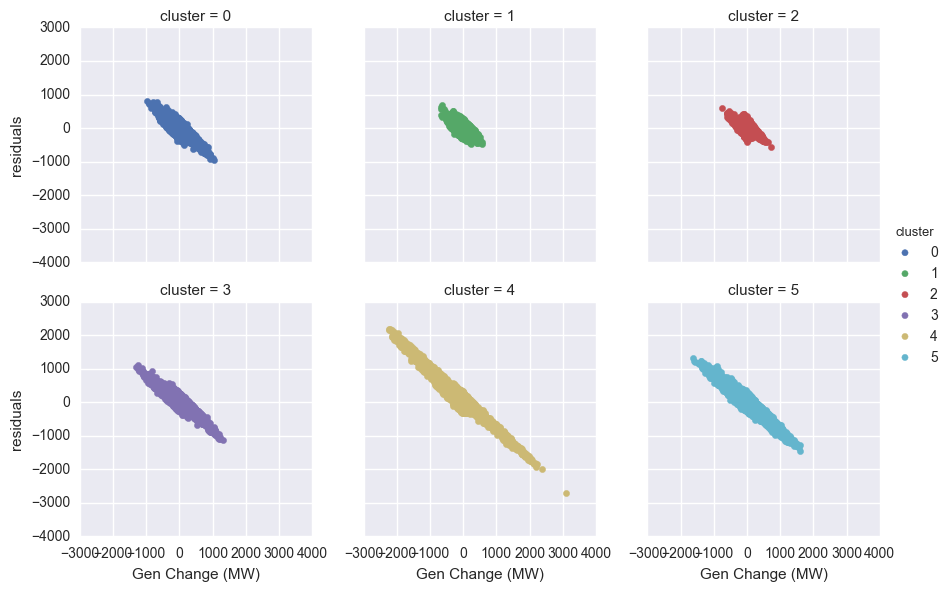

In [29]:
g = sns.FacetGrid(y_lm_resids, hue='cluster', col='cluster',
                  col_wrap=3)
g.map(plt.scatter, 'Gen Change (MW)', 'residuals')
g.add_legend()

## XGBoost

In [14]:
from xgboost import XGBRegressor

In [15]:
model = XGBRegressor()

In [16]:
subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(subsample=subsample)

In [18]:
grid_search = GridSearchCV(model, param_grid, n_jobs=-1, verbose=3)

In [19]:
result = grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] subsample=0.1 ...................................................
[CV] subsample=0.1 ...................................................
[CV] subsample=0.1 ...................................................
[CV] subsample=0.2 ...................................................
[CV] .......................... subsample=0.1, score=0.484954 -   0.4s
[CV] subsample=0.2 ...................................................
[CV] .......................... subsample=0.1, score=0.457812 -   0.4s
[CV] subsample=0.2 ...................................................
[CV] .......................... subsample=0.1, score=0.432054 -   0.4s
[CV] subsample=0.3 ...................................................
[CV] .......................... subsample=0.2, score=0.489922 -   0.4s
[CV] subsample=0.3 ...................................................
[CV] .......................... subsample=0.2, score=0.405688 -   0.3s
[CV] subsample=0.

[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  2.4min finished


In [20]:
result.cv_results_

{'mean_fit_time': array([ 17.29887025,  17.27616898,  17.9309593 ,  20.16705402,
         21.57488139,  21.970059  ,  20.77520935,  20.17156092,  15.8298982 ]),
 'mean_score_time': array([ 0.37530239,  0.33570194,  0.31040764,  0.32522202,  0.35875694,
         0.3899494 ,  0.2991906 ,  0.38670103,  0.22519708]),
 'mean_test_score': array([ 0.4582734 ,  0.45265404,  0.47174388,  0.46991596,  0.47000372,
         0.46260688,  0.47730961,  0.47364352,  0.47836477]),
 'mean_train_score': array([ 0.52659795,  0.53019258,  0.53201711,  0.53158389,  0.53369591,
         0.53187077,  0.53222026,  0.53103841,  0.53230937]),
 'param_subsample': masked_array(data = [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 1.0],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'params': ({'subsample': 0.1},
  {'subsample': 0.2},
  {'subsample': 0.3},
  {'subsample': 0.4},
  {'subsample': 0.5},
  {'subsample': 0.6},
  {'subsample': 0.7},
  {'subsample': 0.8},
  {'subs

In [22]:
model = XGBRegressor()

In [23]:
colsample_bytree = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(colsample_bytree=colsample_bytree)

In [24]:
grid_search = GridSearchCV(model, param_grid, n_jobs=-1, verbose=3)

In [25]:
result = grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] colsample_bytree=0.1 ............................................
[CV] colsample_bytree=0.1 ............................................
[CV] colsample_bytree=0.1 ............................................
[CV] colsample_bytree=0.2 ............................................
[CV] ................... colsample_bytree=0.1, score=0.164646 -   0.2s
[CV] colsample_bytree=0.2 ............................................
[CV] ................... colsample_bytree=0.1, score=0.163248 -   0.2s
[CV] colsample_bytree=0.2 ............................................
[CV] ................... colsample_bytree=0.1, score=0.149747 -   0.2s
[CV] colsample_bytree=0.3 ............................................
[CV] ................... colsample_bytree=0.2, score=0.270653 -   0.3s
[CV] colsample_bytree=0.3 ............................................
[CV] ................... colsample_bytree=0.2, score=0.277469 -   0.4s
[CV] colsample_by

[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.5min finished


In [26]:
result.cv_results_

{'mean_fit_time': array([  4.56124123,   6.81195768,   8.10874836,   9.60875932,
         12.16170565,  14.600293  ,  17.21607868,  16.53451133,  15.66608071]),
 'mean_score_time': array([ 0.22303112,  0.37348668,  0.32521661,  0.35028831,  0.35460496,
         0.38649503,  0.35863702,  0.32337038,  0.23110159]),
 'mean_test_score': array([ 0.15921352,  0.26313523,  0.3457365 ,  0.41064376,  0.43871338,
         0.45083418,  0.45887504,  0.45801704,  0.47836477]),
 'mean_train_score': array([ 0.16892206,  0.31116065,  0.39683733,  0.46549971,  0.49976069,
         0.51085103,  0.51879221,  0.52348525,  0.53230937]),
 'param_colsample_bytree': masked_array(data = [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 1.0],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'params': ({'colsample_bytree': 0.1},
  {'colsample_bytree': 0.2},
  {'colsample_bytree': 0.3},
  {'colsample_bytree': 0.4},
  {'colsample_bytree': 0.5},
  {'colsample_bytree': 0.6},
  {

In [27]:
model = XGBRegressor()

In [28]:
colsample_bylevel = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(colsample_bylevel=colsample_bylevel)

In [29]:
grid_search = GridSearchCV(model, param_grid, n_jobs=-1, verbose=3)

In [30]:
result = grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] colsample_bylevel=0.1 ...........................................
[CV] colsample_bylevel=0.1 ...........................................
[CV] colsample_bylevel=0.1 ...........................................
[CV] colsample_bylevel=0.2 ...........................................
[CV] .................. colsample_bylevel=0.1, score=0.236454 -   0.2s
[CV] colsample_bylevel=0.2 ...........................................
[CV] .................. colsample_bylevel=0.1, score=0.230266 -   0.3s
[CV] colsample_bylevel=0.2 ...........................................
[CV] .................. colsample_bylevel=0.1, score=0.221978 -   0.3s
[CV] colsample_bylevel=0.3 ...........................................
[CV] .................. colsample_bylevel=0.2, score=0.389605 -   0.3s
[CV] colsample_bylevel=0.3 ...........................................
[CV] .................. colsample_bylevel=0.2, score=0.357623 -   0.3s
[CV] ............

[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.6min finished


In [31]:
result.cv_results_

{'mean_fit_time': array([  5.58680964,   7.96834898,   9.22394466,  11.17805529,
         14.44551174,  14.79537845,  16.52017864,  16.49024232,  16.76054573]),
 'mean_score_time': array([ 0.27904503,  0.30942973,  0.3542637 ,  0.47181129,  0.36044025,
         0.49709463,  0.39499768,  0.40493266,  0.27615031]),
 'mean_test_score': array([ 0.22956596,  0.36957139,  0.42193826,  0.43811555,  0.44750804,
         0.45014643,  0.45677407,  0.47150803,  0.47836477]),
 'mean_train_score': array([ 0.2551972 ,  0.4250602 ,  0.46792848,  0.49801298,  0.50912125,
         0.51348689,  0.52657848,  0.52464538,  0.53230937]),
 'param_colsample_bylevel': masked_array(data = [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 1.0],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'params': ({'colsample_bylevel': 0.1},
  {'colsample_bylevel': 0.2},
  {'colsample_bylevel': 0.3},
  {'colsample_bylevel': 0.4},
  {'colsample_bylevel': 0.5},
  {'colsample_bylevel': 0.

In [32]:
model = XGBRegressor()

In [33]:
max_depth = [3, 6, 9]
n_estimators = [100, 250, 500]
reg_alpha = [1e-5, 1e-3, 0.1]
reg_lambda = [1e-3, 0.1, 1]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators,
                  reg_alpha=reg_alpha, reg_lambda=reg_lambda)

In [35]:
grid_search = GridSearchCV(model, param_grid, n_jobs=-1, verbose=2)

In [36]:
result = grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] n_estimators=100, reg_lambda=0.001, reg_alpha=1e-05, max_depth=3 
[CV] n_estimators=100, reg_lambda=0.001, reg_alpha=1e-05, max_depth=3 
[CV] n_estimators=100, reg_lambda=0.001, reg_alpha=1e-05, max_depth=3 
[CV] n_estimators=100, reg_lambda=0.1, reg_alpha=1e-05, max_depth=3 ..
[CV]  n_estimators=100, reg_lambda=0.1, reg_alpha=1e-05, max_depth=3 -   0.6s
[CV]  n_estimators=100, reg_lambda=0.001, reg_alpha=1e-05, max_depth=3 -   0.6s
[CV] n_estimators=100, reg_lambda=0.1, reg_alpha=1e-05, max_depth=3 ..
[CV]  n_estimators=100, reg_lambda=0.001, reg_alpha=1e-05, max_depth=3 -   0.7s
[CV] n_estimators=100, reg_lambda=0.1, reg_alpha=1e-05, max_depth=3 ..
[CV] n_estimators=100, reg_lambda=1, reg_alpha=1e-05, max_depth=3 ....
[CV]  n_estimators=100, reg_lambda=0.001, reg_alpha=1e-05, max_depth=3 -   0.6s
[CV] n_estimators=100, reg_lambda=1, reg_alpha=1e-05, max_depth=3 ....
[CV]  n_estimators=100, reg_lambda=0.1, reg_alpha=1e

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.1min


[CV]  n_estimators=250, reg_lambda=1, reg_alpha=1e-05, max_depth=3 -   0.8s
[CV] n_estimators=250, reg_lambda=0.001, reg_alpha=0.001, max_depth=3 
[CV]  n_estimators=250, reg_lambda=1, reg_alpha=1e-05, max_depth=3 -   0.9s
[CV] n_estimators=250, reg_lambda=0.001, reg_alpha=0.001, max_depth=3 
[CV]  n_estimators=250, reg_lambda=1, reg_alpha=1e-05, max_depth=3 -   0.8s
[CV] n_estimators=250, reg_lambda=0.1, reg_alpha=0.001, max_depth=3 ..
[CV]  n_estimators=250, reg_lambda=0.001, reg_alpha=0.001, max_depth=3 -   0.8s
[CV] n_estimators=250, reg_lambda=0.1, reg_alpha=0.001, max_depth=3 ..
[CV]  n_estimators=250, reg_lambda=0.001, reg_alpha=0.001, max_depth=3 -   0.8s
[CV] n_estimators=250, reg_lambda=0.1, reg_alpha=0.001, max_depth=3 ..
[CV]  n_estimators=250, reg_lambda=0.001, reg_alpha=0.001, max_depth=3 -   1.0s
[CV] n_estimators=250, reg_lambda=1, reg_alpha=0.001, max_depth=3 ....
[CV]  n_estimators=250, reg_lambda=0.1, reg_alpha=0.001, max_depth=3 -   0.7s
[CV] n_estimators=250, reg_l

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 56.3min


[CV]  n_estimators=500, reg_lambda=0.001, reg_alpha=0.1, max_depth=6 -   4.6s
[CV] n_estimators=500, reg_lambda=0.1, reg_alpha=0.1, max_depth=6 ....
[CV]  n_estimators=500, reg_lambda=0.001, reg_alpha=0.1, max_depth=6 -   4.3s
[CV] n_estimators=500, reg_lambda=1, reg_alpha=0.1, max_depth=6 ......
[CV]  n_estimators=500, reg_lambda=0.1, reg_alpha=0.1, max_depth=6 -   4.0s
[CV] n_estimators=500, reg_lambda=1, reg_alpha=0.1, max_depth=6 ......
[CV]  n_estimators=500, reg_lambda=0.1, reg_alpha=0.1, max_depth=6 -   4.1s
[CV] n_estimators=500, reg_lambda=1, reg_alpha=0.1, max_depth=6 ......
[CV]  n_estimators=500, reg_lambda=0.1, reg_alpha=0.1, max_depth=6 -   4.5s
[CV] n_estimators=100, reg_lambda=0.001, reg_alpha=1e-05, max_depth=9 
[CV]  n_estimators=100, reg_lambda=0.001, reg_alpha=1e-05, max_depth=9 -   1.2s
[CV] n_estimators=100, reg_lambda=0.001, reg_alpha=1e-05, max_depth=9 
[CV]  n_estimators=500, reg_lambda=1, reg_alpha=0.1, max_depth=6 -   4.8s
[CV] n_estimators=100, reg_lambda=0.

[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 134.4min finished


In [37]:
import cPickle as pickle

In [38]:
pickle.dump((grid_search, result), open( "xgb gridsearch and results.pkl", "wb" ) )

In [39]:
result.cv_results_

{'mean_fit_time': array([  22.47146734,   19.85001024,   18.88750442,   19.05822746,
          18.78651031,   20.00944002,   21.43022664,   23.52011832,
          18.54295969,   45.00260838,   45.99241924,   47.29698006,
          47.67425768,   43.60707927,   44.10489106,   44.84957798,
          43.919686  ,   43.47668465,   86.81721862,   86.67804432,
          91.35499477,  102.640498  ,   95.7173396 ,   96.57667494,
         102.3701551 ,   95.73338199,   94.18298801,   39.80882366,
          43.65931567,   42.42765705,   38.12971965,   38.45218102,
          38.24791106,   37.63723095,   38.28630408,   40.42925262,
         105.61946464,  108.43322961,  107.24544835,  107.80645768,
         103.35916114,   97.95467575,   97.98183091,   99.43998098,
         107.10949628,  202.54374401,  194.41516336,  204.30298233,
         313.67145197,  223.47959693,  188.01607633,  189.07257533,
         183.10826127,  187.89160872,   62.74625071,   61.75910044,
          62.5911816 ,   63.483

In [41]:
result.best_estimator_

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=250, nthread=-1,
       objective='reg:linear', reg_alpha=0.1, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [40]:
grid_search.score(X_va_scaled, y_va)

0.52178018832808326

## Try XGBoost on non-scaled data
Turns out this works better

In [42]:
xgb = XGBRegressor(n_estimators=250, reg_alpha=0.1)

In [43]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=250, nthread=-1,
       objective='reg:linear', reg_alpha=0.1, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [44]:
xgb.score(X_va, y_va)

0.54909280212343337

In [46]:
y_pr = xgb.predict(X_va)

In [47]:
y_xgb_resids = pd.DataFrame(dict(zip(['Gen Change (MW)', 'y_pr', 'cluster'],
                               [y_va.values, y_pr, X.loc[X['Year'].isin([2012, 2013]),'cluster'].values])))

In [50]:
y_xgb_resids.loc[:,'residuals'] = y_xgb_resids.loc[:,'y_pr'] - y_xgb_resids.loc[:,'Gen Change (MW)']

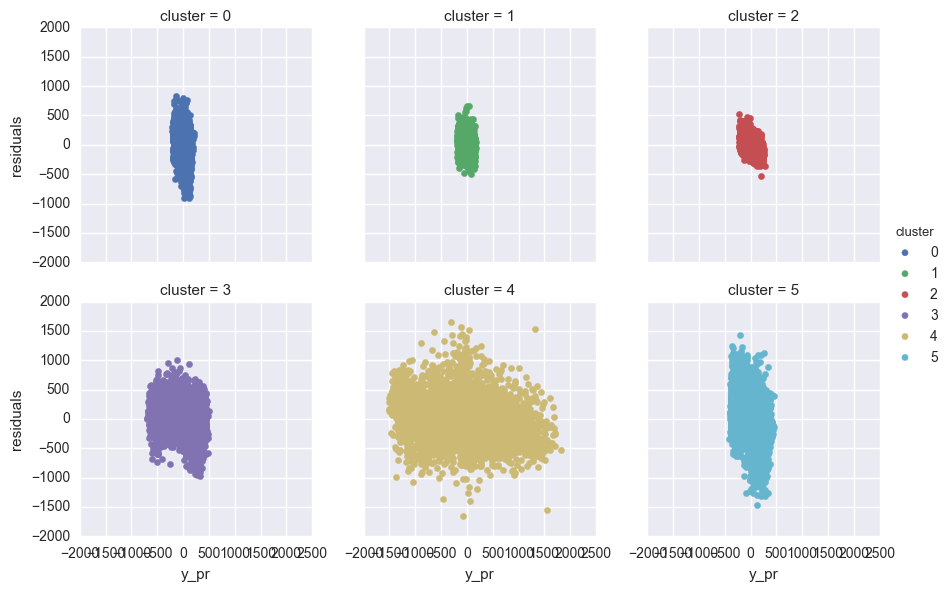

In [51]:
g = sns.FacetGrid(y_xgb_resids, hue='cluster', col='cluster',
                  col_wrap=3)
g.map(plt.scatter, 'y_pr', 'residuals')
g.add_legend()

In [52]:
y_xgb_resids.describe()

,Gen Change (MW),cluster,y_pr,residuals
count,105264.000000,105264.000000,105264.000000,105264.000000
mean,0.072684,2.500000,-4.463920,-4.536561
std,252.875892,1.707833,179.048598,169.744599
min,-2236.000000,0.000000,-1508.438721,-1661.269684
25%,-54.000000,1.000000,-71.290184,-66.515215
50%,0.000000,2.500000,3.031837,-1.428239
75%,55.000000,4.000000,62.890798,58.265282
max,3104.000000,5.000000,1829.738892,1646.675659
